Iteration 500: ρ = 0.754, λ = 0.906, σ_ε = 1.213, σ_ξ = 0.257, σ_κ = 0.548, acceptance = 0.566
Iteration 1000: ρ = 0.926, λ = 1.082, σ_ε = 1.187, σ_ξ = 0.315, σ_κ = 0.44, acceptance = 0.511
Iteration 1500: ρ = 0.931, λ = 0.998, σ_ε = 1.036, σ_ξ = 0.257, σ_κ = 0.324, acceptance = 0.475
Iteration 2000: ρ = 0.93, λ = 0.953, σ_ε = 1.061, σ_ξ = 0.317, σ_κ = 0.357, acceptance = 0.45
Iteration 2500: ρ = 0.845, λ = 0.898, σ_ε = 1.095, σ_ξ = 0.23, σ_κ = 0.554, acceptance = 0.429
Iteration 3000: ρ = 0.75, λ = 1.017, σ_ε = 1.245, σ_ξ = 0.229, σ_κ = 0.716, acceptance = 0.439
Iteration 3500: ρ = 0.828, λ = 1.021, σ_ε = 1.153, σ_ξ = 0.249, σ_κ = 0.746, acceptance = 0.45
Iteration 4000: ρ = 0.859, λ = 0.958, σ_ε = 1.004, σ_ξ = 0.293, σ_κ = 0.727, acceptance = 0.456
Iteration 4500: ρ = 0.8, λ = 0.884, σ_ε = 0.874, σ_ξ = 0.214, σ_κ = 0.738, acceptance = 0.454
Iteration 5000: ρ = 0.917, λ = 0.946, σ_ε = 1.062, σ_ξ = 0.234, σ_κ = 0.528, acceptance = 0.448
Final acceptance rate: 0.448
Estimated ρ:        

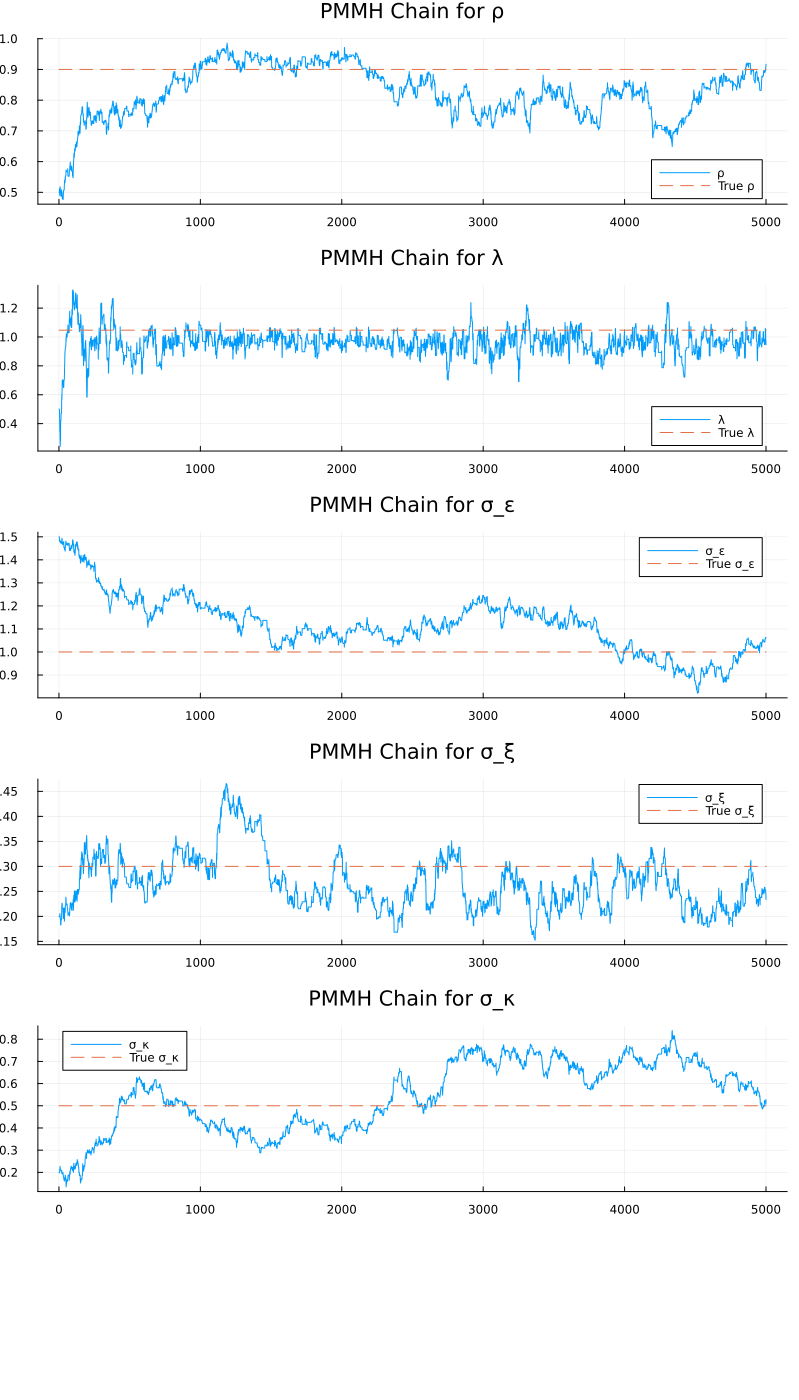

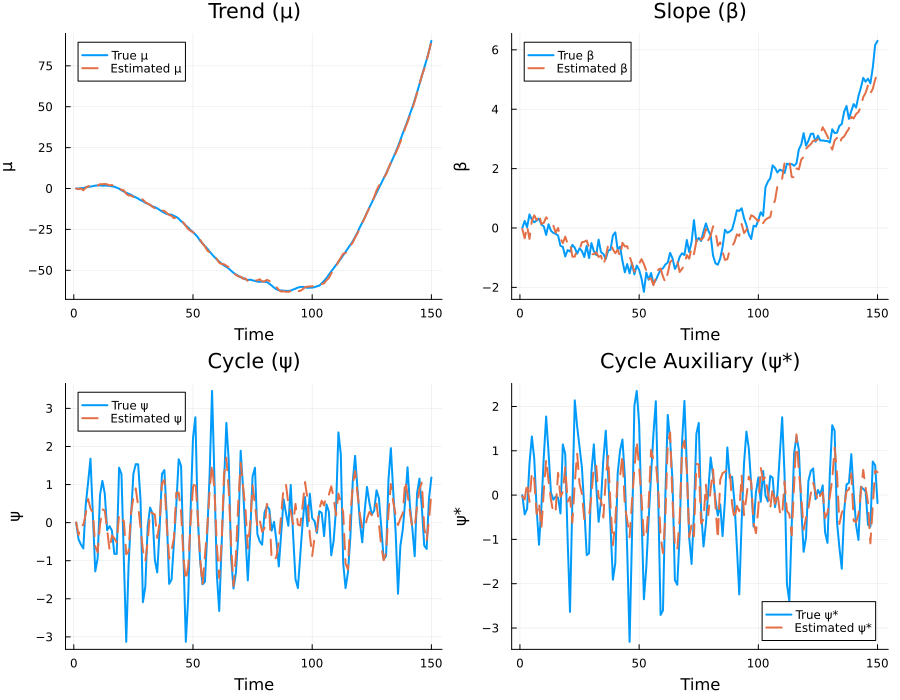

In [2]:
using Random
using Distributions
using StatsBase
using Plots

# ================================
# 1. Generate Synthetic Data for the New Model
# ================================

Random.seed!(42)

# True parameters for the state-space model
true_rho         = 0.9            # damping factor for the cycle (should be in (0,1))
true_lambda_c    = π/3            # cycle frequency (radians), between 0 and π
true_sigma_epsilon = 1.0          # observation noise std
true_sigma_xi    = 0.3            # trend drift noise std
true_sigma_kappa = 0.5            # cyclical shock noise std

T = 150  # number of time steps

# Allocate arrays for the states and observations
mu_true     = zeros(T)
beta_true   = zeros(T)
psi_true    = zeros(T)
psi_star_true = zeros(T)
y_obs       = zeros(T)

# Initial states (set to zero or small random values)
mu_true[1]      = 0.0
beta_true[1]    = 0.0
psi_true[1]     = 0.0
psi_star_true[1]= 0.0

# Precompute rotation matrix for the cycle
rot = [cos(true_lambda_c) sin(true_lambda_c);
       -sin(true_lambda_c) cos(true_lambda_c)]

# Generate the data recursively
# t = 1 is already set; now simulate for t = 2:T
for t in 2:T
    # Trend updates:
    mu_true[t]   = mu_true[t-1] + beta_true[t-1]
    beta_true[t] = beta_true[t-1] + rand(Normal(0, true_sigma_xi))
    
    # Cycle update:
    # Form the previous cycle state vector.
    cycle_prev = [psi_true[t-1], psi_star_true[t-1]]
    # Draw two independent shocks for the cycle.
    noise = rand(Normal(0, true_sigma_kappa), 2)
    cycle_new = true_rho * (rot * cycle_prev) + noise
    psi_true[t]      = cycle_new[1]
    psi_star_true[t] = cycle_new[2]
    
    # Observation equation:
    y_obs[t] = mu_true[t] + psi_true[t] + rand(Normal(0, true_sigma_epsilon))
end

# ================================
# 2. Particle Filter Function for the New Model
# ================================

"""
    particle_filter(y_obs, ρ, λ, σ_ε, σ_ξ, σ_κ; N=500)

Runs a particle filter for the state-space model:
  
  Trend:
    μₜ = μₜ₋₁ + βₜ₋₁
    βₜ = βₜ₋₁ + ξₜ, ξₜ ~ N(0, σ_ξ)
  
  Cycle (first order):
    [ψₜ, ψₜ*]' = ρ * R(λ) * [ψₜ₋₁, ψₜ₋₁*]' + [κₜ, κₜ*]', κₜ, κₜ* ~ N(0, σ_κ)
  
  Observation:
    yₜ = μₜ + ψₜ + εₜ, εₜ ~ N(0, σ_ε)

Returns a tuple: (log_likelihood, filtered_means) where filtered_means contains
the estimated trend μₜ at each time step.
"""
function particle_filter(y_obs, ρ, λ, σ_ε, σ_ξ, σ_κ; N=500)
    T = length(y_obs)
    # Allocate matrices for each state component (dimensions: time x particles)
    particles_mu      = zeros(T, N)
    particles_beta    = zeros(T, N)
    particles_psi     = zeros(T, N)
    particles_psistar = zeros(T, N)
    weights = zeros(T, N)
    filtered_mu = zeros(T)
    log_likelihood = 0.0

    # Initialization:
    # Assume initial distributions for the states:
    particles_mu[1, :]      = rand(Normal(0,1), N)
    particles_beta[1, :]    = rand(Normal(0,1), N)
    particles_psi[1, :]     = rand(Normal(0,1), N)
    particles_psistar[1, :] = rand(Normal(0,1), N)

    # Weight the initial particles using the observation likelihood:
    for i in 1:N
        mean_obs = particles_mu[1,i] + particles_psi[1,i]
        weights[1, i] = pdf(Normal(mean_obs, σ_ε), y_obs[1])
    end
    wsum = sum(weights[1, :])
    weights[1, :] ./= wsum
    log_likelihood += log(wsum / N)
    filtered_mu[1] = sum(particles_mu[1, :] .* weights[1, :])

    # Precompute the rotation matrix for the cycle update
    rot = [cos(λ) sin(λ); -sin(λ) cos(λ)]

    for t in 2:T
        # Resample indices according to weights from time t-1
        indices = sample(1:N, Weights(weights[t-1, :]), N, replace=true)

        for i in 1:N
            # Retrieve the resampled states:
            μ_prev   = particles_mu[t-1, indices[i]]
            β_prev   = particles_beta[t-1, indices[i]]
            ψ_prev   = particles_psi[t-1, indices[i]]
            ψs_prev  = particles_psistar[t-1, indices[i]]

            # Trend update:
            μ_new = μ_prev + β_prev
            β_new = β_prev + rand(Normal(0, σ_ξ))

            # Cycle update:
            cycle_prev = [ψ_prev, ψs_prev]
            noise = rand(Normal(0, σ_κ), 2)
            cycle_new = ρ * (rot * cycle_prev) + noise
            ψ_new  = cycle_new[1]
            ψs_new = cycle_new[2]

            # Store new states:
            particles_mu[t, i]      = μ_new
            particles_beta[t, i]    = β_new
            particles_psi[t, i]     = ψ_new
            particles_psistar[t, i] = ψs_new

            # Compute the likelihood for the observation at time t:
            mean_obs = μ_new + ψ_new
            weights[t, i] = pdf(Normal(mean_obs, σ_ε), y_obs[t])
        end

        # Normalize weights and update log-likelihood:
        wsum = sum(weights[t, :])
        if wsum == 0
            weights[t, :] .= 1.0 / N
        else
            weights[t, :] ./= wsum
        end
        log_likelihood += log(wsum / N)
        filtered_mu[t] = sum(particles_mu[t, :] .* weights[t, :])
    end

    return log_likelihood, filtered_mu
end

# ================================
# 3. PMMH to Estimate (ρ, λ, σ_ε, σ_ξ, σ_κ)
# ================================

"""
    PMMH(y_obs; n_iter=3000, N=500)

Runs the Particle Marginal Metropolis–Hastings (PMMH) algorithm to estimate the
parameters ρ, λ, σ_ε, σ_ξ, and σ_κ of the state-space model.

Priors:
  σ_ε ~ Exponential(1)
  σ_ξ ~ Exponential(1)
  σ_κ ~ Exponential(1)
  ρ ~ Uniform(0,1)
  λ ~ Uniform(0, π)

Returns a tuple:
 (ρ_samples, λ_samples, σ_ε_samples, σ_ξ_samples, σ_κ_samples, loglikelihoods)
"""
function PMMH(y_obs; n_iter=3000, N=500)
    # Arrays to store samples
    rho_samples         = zeros(n_iter)
    lambda_samples      = zeros(n_iter)
    sigma_epsilon_samples = zeros(n_iter)
    sigma_xi_samples    = zeros(n_iter)
    sigma_kappa_samples = zeros(n_iter)
    loglikelihoods      = zeros(n_iter)

    # Initialize parameters (choose valid starting values)
    rho_current         = 0.5
    lambda_current      = 0.5       # in radians, between 0 and π
    sigma_epsilon_current = 1.5
    sigma_xi_current    = 0.2
    sigma_kappa_current = 0.2

    ll_current, _ = particle_filter(y_obs, rho_current, lambda_current, sigma_epsilon_current, sigma_xi_current, sigma_kappa_current; N=N)

    # Store initial values:
    rho_samples[1]         = rho_current
    lambda_samples[1]      = lambda_current
    sigma_epsilon_samples[1] = sigma_epsilon_current
    sigma_xi_samples[1]    = sigma_xi_current
    sigma_kappa_samples[1] = sigma_kappa_current
    loglikelihoods[1]      = ll_current

    # Proposal standard deviations for random-walk proposals
    prop_std_rho    = 0.01
    prop_std_lambda = 0.05
    prop_std_ε      = 0.01
    prop_std_ξ      = 0.01
    prop_std_κ      = 0.01

    accept_count = 0
    for i in 2:n_iter
        # Propose new parameters via a random-walk:
        rho_proposal    = rho_current + randn() * prop_std_rho
        lambda_proposal = lambda_current + randn() * prop_std_lambda
        sigma_epsilon_proposal = sigma_epsilon_current + randn() * prop_std_ε
        sigma_xi_proposal    = sigma_xi_current + randn() * prop_std_ξ
        sigma_kappa_proposal = sigma_kappa_current + randn() * prop_std_κ

        # Enforce parameter constraints:
        if (rho_proposal <= 0 || rho_proposal >= 1 ||
            lambda_proposal <= 0 || lambda_proposal >= π ||
            sigma_epsilon_proposal <= 0 || sigma_xi_proposal <= 0 || sigma_kappa_proposal <= 0)
            # Reject proposal by keeping current parameters
            rho_samples[i]         = rho_current
            lambda_samples[i]      = lambda_current
            sigma_epsilon_samples[i] = sigma_epsilon_current
            sigma_xi_samples[i]    = sigma_xi_current
            sigma_kappa_samples[i] = sigma_kappa_current
            loglikelihoods[i]      = ll_current
            continue
        end

        # Run particle filter for the proposed parameters:
        ll_proposal, _ = particle_filter(y_obs, rho_proposal, lambda_proposal, sigma_epsilon_proposal, sigma_xi_proposal, sigma_kappa_proposal; N=N)

        # Compute log-priors:
        # For σ's, we use Exponential(1) priors; for ρ and λ, Uniform priors.
        log_prior_current = log(pdf(Exponential(1), sigma_epsilon_current)) +
                            log(pdf(Exponential(1), sigma_xi_current)) +
                            log(pdf(Exponential(1), sigma_kappa_current)) +
                            log(1.0) + log(1.0/π)  # ρ ~ Uniform(0,1) and λ ~ Uniform(0,π)
        log_prior_proposal = log(pdf(Exponential(1), sigma_epsilon_proposal)) +
                             log(pdf(Exponential(1), sigma_xi_proposal)) +
                             log(pdf(Exponential(1), sigma_kappa_proposal)) +
                             log(1.0) + log(1.0/π)

        log_prior_current = 0
        log_prior_proposal = 0

        log_alpha = (ll_proposal + log_prior_proposal) - (ll_current + log_prior_current)
        if log(rand()) < log_alpha
            rho_current         = rho_proposal
            lambda_current      = lambda_proposal
            sigma_epsilon_current = sigma_epsilon_proposal
            sigma_xi_current    = sigma_xi_proposal
            sigma_kappa_current = sigma_kappa_proposal
            ll_current          = ll_proposal
            accept_count       += 1
        end

        rho_samples[i]         = rho_current
        lambda_samples[i]      = lambda_current
        sigma_epsilon_samples[i] = sigma_epsilon_current
        sigma_xi_samples[i]    = sigma_xi_current
        sigma_kappa_samples[i] = sigma_kappa_current
        loglikelihoods[i]      = ll_current

        if mod(i, 500) == 0
            println("Iteration $i: ρ = $(round(rho_current, digits=3)), λ = $(round(lambda_current, digits=3)), σ_ε = $(round(sigma_epsilon_current, digits=3)), σ_ξ = $(round(sigma_xi_current, digits=3)), σ_κ = $(round(sigma_kappa_current, digits=3)), acceptance = $(round(accept_count/i, digits=3))")
        end
    end

    println("Final acceptance rate: $(round(accept_count/n_iter, digits=3))")
    return rho_samples, lambda_samples, sigma_epsilon_samples, sigma_xi_samples, sigma_kappa_samples, loglikelihoods
end

# ================================
# 4. Run PMMH and Estimate Parameters
# ================================

n_iter = 5000
rho_chain, lambda_chain, sigma_epsilon_chain, sigma_xi_chain, sigma_kappa_chain, ll_chain = 
    PMMH(y_obs; n_iter=n_iter, N=2000)

# Discard burn-in (e.g., first 20000 iterations)
burn_in = 2000
est_rho         = mean(rho_chain[burn_in+1:end])
est_lambda      = mean(lambda_chain[burn_in+1:end])
est_sigma_epsilon = mean(sigma_epsilon_chain[burn_in+1:end])
est_sigma_xi    = mean(sigma_xi_chain[burn_in+1:end])
est_sigma_kappa = mean(sigma_kappa_chain[burn_in+1:end])

println("Estimated ρ:         $(round(est_rho, digits=3)) (true: $(true_rho))")
println("Estimated λ:         $(round(est_lambda, digits=3)) (true: $(true_lambda_c))")
println("Estimated σ_ε:       $(round(est_sigma_epsilon, digits=3)) (true: $(true_sigma_epsilon))")
println("Estimated σ_ξ:       $(round(est_sigma_xi, digits=3)) (true: $(true_sigma_xi))")
println("Estimated σ_κ:       $(round(est_sigma_kappa, digits=3)) (true: $(true_sigma_kappa))")

# ================================
# 5. Obtain State Estimates Using the Particle Filter
# ================================

ll_final, state_estimates = particle_filter(y_obs, est_rho, est_lambda, est_sigma_epsilon, est_sigma_xi, est_sigma_kappa; N=2000)

# ================================
# 6. Plotting the Results
# ================================

# Plot parameter chains
p1 = plot(rho_chain, label="ρ", title="PMMH Chain for ρ")
plot!(p1, fill(true_rho, length(rho_chain)), label="True ρ", linestyle=:dash)

p2 = plot(lambda_chain, label="λ", title="PMMH Chain for λ")
plot!(p2, fill(true_lambda_c, length(lambda_chain)), label="True λ", linestyle=:dash)

p3 = plot(sigma_epsilon_chain, label="σ_ε", title="PMMH Chain for σ_ε")
plot!(p3, fill(true_sigma_epsilon, length(sigma_epsilon_chain)), label="True σ_ε", linestyle=:dash)

p4 = plot(sigma_xi_chain, label="σ_ξ", title="PMMH Chain for σ_ξ")
plot!(p4, fill(true_sigma_xi, length(sigma_xi_chain)), label="True σ_ξ", linestyle=:dash)

p5 = plot(sigma_kappa_chain, label="σ_κ", title="PMMH Chain for σ_κ")
plot!(p5, fill(true_sigma_kappa, length(sigma_kappa_chain)), label="True σ_κ", linestyle=:dash)


# Combine all plots and display
plot(p1, p2, p3, p4, p5, layout=(6,1), size=(800, 1400))
display(plot(p1, p2, p3, p4, p5, layout=(6,1), size=(800, 1400)))


# ================================
# 7. Particle Filter for All States (Filtered Means)
# ================================
"""
    particle_filter_all_states(y_obs, ρ, λ, σ_ε, σ_ξ, σ_κ; N=500)

Runs a particle filter for the state-space model and returns filtered estimates
for all state components: μ (trend), β (slope), ψ (cycle), and ψ* (cycle auxiliary).

Returns a named tuple with:
  mu:      filtered means of the trend state
  beta:    filtered means of the slope state
  psi:     filtered means of the cycle state
  psi_star:filtered means of the cycle auxiliary state
"""
function particle_filter_all_states(y_obs, ρ, λ, σ_ε, σ_ξ, σ_κ; N=500)
    T = length(y_obs)
    # Allocate matrices for particles (time x particles)
    particles_mu      = zeros(T, N)
    particles_beta    = zeros(T, N)
    particles_psi     = zeros(T, N)
    particles_psistar = zeros(T, N)
    weights = zeros(T, N)

    # Arrays to store filtered (weighted mean) estimates
    filtered_mu      = zeros(T)
    filtered_beta    = zeros(T)
    filtered_psi     = zeros(T)
    filtered_psistar = zeros(T)

    # Initialization: use your same initial distributions
    particles_mu[1, :]      = rand(Normal(0, 1), N)
    particles_beta[1, :]    = rand(Normal(0, 1), N)
    particles_psi[1, :]     = rand(Normal(0, 1), N)
    particles_psistar[1, :] = rand(Normal(0, 1), N)

    # Weight initial particles using the observation likelihood:
    for i in 1:N
        mean_obs = particles_mu[1, i] + particles_psi[1, i]
        weights[1, i] = pdf(Normal(mean_obs, σ_ε), y_obs[1])
    end
    wsum = sum(weights[1, :])
    weights[1, :] ./= wsum

    # Compute filtered estimates for t = 1:
    filtered_mu[1]      = sum(particles_mu[1, :] .* weights[1, :])
    filtered_beta[1]    = sum(particles_beta[1, :] .* weights[1, :])
    filtered_psi[1]     = sum(particles_psi[1, :] .* weights[1, :])
    filtered_psistar[1] = sum(particles_psistar[1, :] .* weights[1, :])

    # Precompute rotation matrix for the cycle update
    rot = [cos(λ) sin(λ); -sin(λ) cos(λ)]

    for t in 2:T
        # Resample indices based on weights from time t-1
        indices = sample(1:N, Weights(weights[t-1, :]), N, replace=true)

        for i in 1:N
            # Retrieve the resampled states:
            μ_prev   = particles_mu[t-1, indices[i]]
            β_prev   = particles_beta[t-1, indices[i]]
            ψ_prev   = particles_psi[t-1, indices[i]]
            ψs_prev  = particles_psistar[t-1, indices[i]]

            # Trend update:
            μ_new = μ_prev + β_prev
            β_new = β_prev + rand(Normal(0, σ_ξ))

            # Cycle update:
            cycle_prev = [ψ_prev, ψs_prev]
            noise = rand(Normal(0, σ_κ), 2)
            cycle_new = ρ * (rot * cycle_prev) + noise
            ψ_new  = cycle_new[1]
            ψs_new = cycle_new[2]

            # Store new states:
            particles_mu[t, i]      = μ_new
            particles_beta[t, i]    = β_new
            particles_psi[t, i]     = ψ_new
            particles_psistar[t, i] = ψs_new

            # Compute weight based on observation likelihood:
            mean_obs = μ_new + ψ_new
            weights[t, i] = pdf(Normal(mean_obs, σ_ε), y_obs[t])
        end

        # Normalize weights:
        wsum = sum(weights[t, :])
        if wsum == 0
            weights[t, :] .= 1.0 / N
        else
            weights[t, :] ./= wsum
        end

        # Compute filtered (weighted) estimates:
        filtered_mu[t]      = sum(particles_mu[t, :] .* weights[t, :])
        filtered_beta[t]    = sum(particles_beta[t, :] .* weights[t, :])
        filtered_psi[t]     = sum(particles_psi[t, :] .* weights[t, :])
        filtered_psistar[t] = sum(particles_psistar[t, :] .* weights[t, :])
    end

    return (mu = filtered_mu, beta = filtered_beta, psi = filtered_psi, psi_star = filtered_psistar)
end

# ================================
# 8. Obtain Filtered State Estimates Using Estimated Parameters
# ================================
filtered_states = particle_filter_all_states(y_obs, est_rho, est_lambda, est_sigma_epsilon, est_sigma_xi, est_sigma_kappa; N=2000)

# ================================
# 9. Plot the Estimated States Against the True States
# ================================
T_range = 1:T

# Plot for the Trend (μ)
p_mu = plot(T_range, mu_true, label="True μ", lw=2, title="Trend (μ)", xlabel="Time", ylabel="μ")
plot!(p_mu, T_range, filtered_states.mu, label="Estimated μ", lw=2, linestyle=:dash)

# Plot for the Slope (β)
p_beta = plot(T_range, beta_true, label="True β", lw=2, title="Slope (β)", xlabel="Time", ylabel="β")
plot!(p_beta, T_range, filtered_states.beta, label="Estimated β", lw=2, linestyle=:dash)

# Plot for the Cycle (ψ)
p_psi = plot(T_range, psi_true, label="True ψ", lw=2, title="Cycle (ψ)", xlabel="Time", ylabel="ψ")
plot!(p_psi, T_range, filtered_states.psi, label="Estimated ψ", lw=2, linestyle=:dash)

# Plot for the Cycle Auxiliary (ψ*)
p_psistar = plot(T_range, psi_star_true, label="True ψ*", lw=2, title="Cycle Auxiliary (ψ*)", xlabel="Time", ylabel="ψ*")
plot!(p_psistar, T_range, filtered_states.psi_star, label="Estimated ψ*", lw=2, linestyle=:dash)

# Combine plots in a 2x2 layout
plot(p_mu, p_beta, p_psi, p_psistar, layout=(2,2), size=(900,700))